In [1]:
import pymongo
import pandas as pd
#from pandas import Series
import numpy as np
np.set_printoptions(threshold='nan')
from numpy.linalg import inv
from scipy import signal
from scipy.io import wavfile

import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
#from collections import Counter
from bson.objectid import ObjectId
import json
import pprint
from pydub import AudioSegment
import urllib
import fnmatch
import os
import requests
import ffmpy
import subprocess
import librosa
import librosa.display

In [2]:
client = pymongo.MongoClient('localhost',27017)
#client = pymongo.MongoClient('localhost',32768)
db = client.get_database('b=bandhub')

In [3]:
songCol = db.get_collection('songsStream')
vidCol = db.get_collection('mergedVideos')
trackCol = db.get_collection('tracksStream')
postCol = db.get_collection('posts')
[songCol.count(), vidCol.count(), trackCol.count(), postCol.count()]

[425706, 198169, 915582, 494867]

Find mixes with "NumTrack" published tracks, where NumTrack > 3

In [4]:
NumTrackMixes = []
masterSongIDs = []
NumTrack = 4
#zeroTrackMixes = 0
pubTracks = postCol.find({'songAccess':{'$exists': True}}, {'participantsInfo':1 ,'songAccess':1, 'objectId':1})
for docs in pubTracks:
    if(docs['songAccess'] == 1):
        if(len(docs['participantsInfo']['publishedTracks']) == NumTrack):
            #ThreeTrackMixes.append(docs['objectId'])
            NumTrackMixes.append(docs['_id'])
            masterSongIDs.append(docs['objectId'])
countNumTrack = len(NumTrackMixes)

In [5]:
print(countNumTrack)

3571


Storing the published tracks associated with each mix

In [6]:
indexRequired = []
missing_SongID = []
missing_pubtrack = []
for j in range(countNumTrack):
    remix_test = NumTrackMixes[j]
    songID = masterSongIDs[j]
    
    pub_t = []
    rmt1 = postCol.find({'_id': remix_test})
    for docs in rmt1:
        for i in range(NumTrack):
            pub_t.append(docs['participantsInfo']['publishedTracks'][i]['_id'])
    
    songLookUp = songCol.find({'masterSongId' : songID})
    if songLookUp is -1:
        pprint.pprint('Error: SongID not found in Song Collection!')
        missing_SongID.append(songID)
    else:
        for songdocs in songLookUp:
            for i in range(NumTrack):
                if(str(pub_t[i]) not in songdocs['settings']):
                    missing_pubtrack.append(pub_t[i])   
                    continue
                else:
                    gettrack = trackCol.find({'_id' : pub_t[i]})
                    for tdocs in gettrack:
                        #if tdocs['startTimeValue'] is not 0:
                        indexRequired.append(j)

In [7]:
indexRequired = np.unique(indexRequired)
print(len(indexRequired))

3305


In [8]:
print(missing_pubtrack)

[ObjectId('5957c83b3a34ebb1748a4744')]


In [11]:
indexRequired_unproc_nonz = [2, 19, 20, 22, 32, 32, 40, 42, 47, 51, 63, 66, 66, 71, 75, 76, 81, 90, 102, 103, 110, 114, 138, 143, 146, 149, 151, 160, 182, 193, 196, 206, 206, 207, 216, 221, 222, 223, 227, 241, 252, 254, 258, 262, 272, 273, 275, 277, 281, 298, 304, 310, 324, 326, 331, 331, 344, 351, 370, 389, 392, 397, 397, 402, 404, 404, 436, 440, 445, 446, 447, 454, 460, 469, 475, 480, 486, 488, 493, 493, 508, 511, 512, 517, 517, 523, 526, 527, 532, 546, 549, 564, 572, 596, 609, 611, 612, 615, 619, 623, 623, 630, 630, 642, 643, 645, 650, 652, 654, 660, 663, 665, 669, 671, 673, 674, 675, 675, 680, 685, 686, 687, 688, 689, 689, 693, 694, 704, 707, 724, 744, 744, 745, 759, 760, 762, 766, 769, 769, 780, 782, 783, 788, 789, 794, 795, 800, 800, 802, 806, 807, 807, 822, 822, 822, 830, 834, 834, 837, 840, 843, 844, 844, 846, 846, 847, 850, 851, 863, 871, 871, 876, 878, 880, 885, 889, 892, 895, 895, 898, 899, 902, 907, 916, 929, 929, 930, 933, 933, 940, 940, 946, 951, 954, 959, 960, 969, 970, 975, 977, 979, 981, 982, 983, 984, 988, 992, 994, 1000, 1004, 1009, 1009, 1011, 1019, 1024, 1038, 1043, 1043, 1047, 1050, 1050, 1052, 1062, 1067, 1068, 1070, 1090, 1098, 1098, 1099, 1105, 1109, 1109, 1110, 1118, 1122, 1128, 1131, 1137, 1140, 1145, 1148, 1152, 1152, 1170, 1171, 1175, 1184, 1188, 1200, 1200, 1201, 1228, 1230, 1231, 1252, 1256, 1289, 1297, 1301, 1304, 1307, 1309, 1310, 1316, 1316, 1318, 1324, 1325, 1343, 1354, 1363, 1368, 1368, 1369, 1369, 1387, 1398, 1403, 1408, 1422, 1425, 1429, 1435, 1436, 1458, 1464, 1464, 1473, 1475, 1477, 1477, 1484, 1491, 1494, 1497, 1498, 1525, 1528, 1530, 1558, 1565, 1568, 1574, 1595, 1595, 1596, 1616, 1624, 1638, 1643, 1643, 1647, 1654, 1671, 1690, 1694, 1694, 1741, 1812, 1823, 1865, 1895, 1921, 1935, 1956, 1965, 1983, 1997, 1997, 2007, 2009, 2040, 2057, 2062, 2063, 2096, 2103, 2120, 2145, 2148, 2166, 2166, 2178, 2214, 2222, 2229, 2245, 2252, 2258, 2274, 2277, 2277, 2307, 2354, 2358, 2366, 2371, 2376, 2380, 2381, 2390, 2393, 2393, 2409, 2412, 2421, 2427, 2432, 2436, 2443, 2451, 2455, 2469, 2477, 2494, 2524, 2532, 2535, 2537, 2537, 2551, 2560, 2571, 2571, 2576, 2601, 2603, 2606, 2610, 2643, 2684, 2697, 2697, 2708, 2711, 2742, 2766, 2766, 2768, 2776, 2782, 2785, 2785, 2803, 2817, 2834, 2851, 2880, 2884, 2893, 2909, 2936, 2940, 2946, 2949, 2971, 2974, 2977, 2985, 3015, 3035, 3060, 3061, 3061, 3063, 3065, 3085, 3096, 3125, 3145, 3154, 3166, 3203, 3211, 3213, 3225, 3229, 3239, 3240, 3240, 3248, 3272, 3283, 3322, 3368, 3405, 3421, 3421, 3436, 3441, 3449, 3457, 3469, 3483, 3504, 3504, 3510, 3567, 3581, 3598, 3609, 3628, 3636, 3640, 3668, 3694, 3699, 3714, 3746, 3755, 3756, 3771, 3792, 3815, 3859, 3878, 3883, 3883, 3887, 3892, 3892, 3895]

In [13]:
indexRequired_proc = [477, 589, 633, 655, 684, 856, 883, 908, 908, 943, 1005, 1018, 1034, 1087, 1106, 1155, 1156, 1162, 1185, 1270, 1275, 1290, 1294, 1295, 1302, 1315, 1332, 1334, 1356, 1370, 1377, 1378, 1434, 1443, 1446, 1451, 1469, 1481, 1499, 1515, 1537, 1545, 1570, 1570, 1594, 1601, 1602, 1604, 1636, 1636, 1652, 1655, 1659, 1660, 1660, 1662, 1667, 1674, 1674, 1675, 1682, 1696, 1724, 1728, 1730, 1732, 1741, 1750, 1754, 1756, 1760, 1768, 1771, 1780, 1786, 1792, 1793, 1798, 1800, 1800, 1802, 1811, 1811, 1816, 1820, 1822, 1824, 1825, 1827, 1830, 1830, 1846, 1851, 1856, 1856, 1867, 1879, 1889, 1889, 1894, 1894, 1900, 1901, 1903, 1908, 1908, 1909, 1921, 1925, 1930, 1931, 1931, 1933, 1954, 1961, 1971, 1976, 1979, 1983, 1987, 1989, 1993, 1994, 1996, 2000, 2001, 2002, 2006, 2009, 2011, 2014, 2019, 2019, 2025, 2028, 2029, 2035, 2035, 2042, 2046, 2046, 2047, 2047, 2048, 2071, 2077, 2080, 2086, 2097, 2104, 2111, 2114, 2121, 2133, 2137, 2137, 2140, 2146, 2149, 2149, 2150, 2163, 2167, 2171, 2171, 2175, 2183, 2183, 2189, 2190, 2191, 2191, 2193, 2193, 2193, 2199, 2200, 2202, 2209, 2221, 2221, 2225, 2240, 2242, 2247, 2249, 2271, 2271, 2279, 2279, 2284, 2289, 2292, 2292, 2306, 2317, 2327, 2328, 2332, 2332, 2334, 2335, 2364, 2370, 2373, 2374, 2388, 2399, 2410, 2410, 2418, 2433, 2435, 2435, 2441, 2448, 2448, 2461, 2464, 2470, 2475, 2475, 2476, 2479, 2490, 2493, 2495, 2502, 2502, 2510, 2525, 2530, 2541, 2541, 2543, 2545, 2549, 2553, 2554, 2560, 2567, 2573, 2574, 2577, 2584, 2585, 2585, 2599, 2607, 2611, 2618, 2623, 2623, 2627, 2627, 2629, 2642, 2646, 2652, 2660, 2663, 2668, 2675, 2689, 2689, 2693, 2699, 2704, 2707, 2714, 2715, 2720, 2727, 2731, 2739, 2739, 2740, 2740, 2747, 2748, 2749, 2753, 2757, 2763, 2765, 2777, 2778, 2786, 2798, 2810, 2811, 2811, 2822, 2836, 2839, 2842, 2852, 2857, 2858, 2859, 2870, 2875, 2876, 2897, 2900, 2904, 2905, 2916, 2917, 2932, 2934, 2942, 2943, 2947, 2953, 2955, 2959, 2961, 2962, 2972, 2985, 2987, 2988, 2990, 2995, 2997, 2999, 3009, 3010, 3011, 3012, 3015, 3022, 3029, 3029, 3033, 3033, 3034, 3038, 3040, 3043, 3054, 3058, 3062, 3063, 3071, 3077, 3083, 3086, 3095, 3099, 3100, 3100, 3104, 3104, 3106, 3110, 3115, 3118, 3123, 3126, 3127, 3142, 3149, 3153, 3162, 3162, 3167, 3181, 3182, 3183, 3189, 3190, 3208, 3210, 3215, 3215, 3221, 3222, 3224, 3231, 3232, 3234, 3238, 3238, 3242, 3242, 3244, 3247, 3259, 3263, 3265, 3271, 3271, 3275, 3276, 3282, 3294, 3294, 3297, 3308, 3310, 3310, 3313, 3314, 3315, 3320, 3335, 3345, 3358, 3365, 3370, 3371, 3374, 3383, 3383, 3385, 3386, 3391, 3395, 3402, 3403, 3408, 3412, 3412, 3414, 3415, 3415, 3424, 3432, 3444, 3447, 3448, 3450, 3460, 3461, 3468, 3478, 3478, 3479, 3480, 3482, 3484, 3484, 3488, 3488, 3493, 3494, 3497, 3511, 3511, 3512, 3514, 3519, 3520, 3520, 3521, 3523, 3523, 3528, 3531, 3543, 3545, 3547, 3551, 3551, 3562, 3564, 3574, 3585, 3588, 3588, 3594, 3596, 3611, 3611, 3613, 3626, 3631, 3632, 3642, 3642, 3647, 3656, 3657, 3671, 3671, 3673, 3674, 3675, 3676, 3679, 3685, 3692, 3693, 3702, 3711, 3712, 3717, 3719, 3723, 3728, 3730, 3733, 3737, 3738, 3739, 3742, 3743, 3748, 3749, 3750, 3755, 3756, 3759, 3764, 3765, 3765, 3766, 3775, 3783, 3788, 3788, 3793, 3795, 3795, 3796, 3798, 3808, 3811, 3813, 3819, 3821, 3833, 3835, 3840, 3840, 3843, 3852, 3852, 3853, 3859, 3860, 3872, 3875, 3879, 3880, 3884, 3885, 3895, 3896, 3897, 3901, 3902, 3906, 3907]

In [9]:
for ii in range(len(indexRequired)):
    idx = indexRequired[ii]
    #idx = 5
    SongID = masterSongIDs[idx]
    trackID = NumTrackMixes[idx]
    pub_tracks = []
    pub_t_vol = []
    pub_t_vol_ch = []
    ogg_paths = []
    start_times = []
    track_filenames = []
    songDoc = songCol.find({'masterSongId' : SongID})
    rmtDoc = postCol.find({'_id': trackID})
    for docs in songDoc:
        #pprint.pprint(docs)
        #pprint.pprint('============')
        for rdocs in rmtDoc:
            for i in range(NumTrack):
                pub_tracks.append(rdocs['participantsInfo']['publishedTracks'][i]['_id'])
                #pprint.pprint(rdocs['participantsInfo']['publishedTracks'][i]['_id'])
        #pprint.pprint(docs['settings'][str(pub_tracks[i])]['audioChannels'][0])
        for i in range(NumTrack):

            if (str(pub_tracks[i]) not in docs['settings']):
                print('Missing mix coeff')
                continue
            if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0] and 'volume' in docs['settings'][str(pub_tracks[i])]):
                if (docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'] != docs['settings'][str(pub_tracks[i])]['volume']):
                    pprint.pprint(idx)
                    pub_t_vol.append(docs['settings'][str(pub_tracks[i])]['volume'])
                #print(str(pub_tracks[i]))
    #             if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0]):
                    pub_t_vol_ch.append(docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'])
                    pprint.pprint(pub_t_vol)
                    pprint.pprint('============')
                    pprint.pprint(pub_t_vol_ch)
    #                 print('Audichannel')
    #             elif ('volume' in docs['settings'][str(pub_tracks[i])]):

    #                 print('settings')
    #             else:
    #                 print('Missing mix coeff')

    #         if('effectsAudioUrl' in docs['settings'][str(pub_tracks[i])]): 
    #             ogg_paths.append(docs['settings'][str(pub_tracks[i])]['effectsAudioUrl'])
    #             gettrack = trackCol.find({'_id' : pub_tracks[i]})
    #             for tdocs in gettrack:
    #                 start_times.append(tdocs['startTimeValue'])
    #         else:
                    gettrack = trackCol.find({'_id' : pub_tracks[i]})
                    for tdocs in gettrack:
                        #pprint.pprint(tdocs)
                        ogg_paths.append(tdocs['audioChannels'][0]['fileUrl'])
                        start_times.append(tdocs['startTimeValue'])

                    for file in ogg_paths:
                        filePath = file.split('/')
                        track_filenames.append(filePath[- 1])
    #                     pprint.pprint(pub_t_vol)
    #                     pprint.pprint('============')
    #                     pprint.pprint(pub_t_vol_ch)
                    pprint.pprint('============')
                    pprint.pprint(track_filenames)
                    pprint.pprint('============')
                    pprint.pprint(start_times)
            else:
                continue

0
[0.99]
'============'
[0.8873248922413793]
'============'
[u'129ec190-5ebf-453f-9065-b2434d4cbbef.ogg']
'============'
[218135]
29
[0.16]
'============'
[0.4609375]
'============'
[u'5272a0cedf3584b43f000039-5272a0cedf3584b43f00003a.ogg']
'============'
[0]
29
[0.16, 0.69]
'============'
[0.4609375, 0.9694661458333333]
'============'
[u'5272a0cedf3584b43f000039-5272a0cedf3584b43f00003a.ogg',
 u'5272a0cedf3584b43f000039-5272a0cedf3584b43f00003a.ogg',
 u'5272a0cedf3584b43f000039-5272a191df3584b43f00003c.ogg']
'============'
[0, 0]
Missing mix coeff


In [36]:
idx = 29
SongID = masterSongIDs[idx]
trackID = NumTrackMixes[idx]
pub_tracks = []
pub_t_vol = []
pub_t_vol_ch = []
ogg_paths = []
start_times = []
track_filenames = []
songDoc = songCol.find({'masterSongId' : SongID})
rmtDoc = postCol.find({'_id': trackID})
for docs in songDoc:
    #pprint.pprint(docs)
    #pprint.pprint('============')
    for rdocs in rmtDoc:
        for i in range(NumTrack):
            pub_tracks.append(rdocs['participantsInfo']['publishedTracks'][i]['_id'])
    #pprint.pprint(len(pub_tracks))
    for i in range(NumTrack):
        pub_t_vol.append(docs['settings'][str(pub_tracks[i])]['volume'])
        if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0]):
            pub_t_vol_ch.append(docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'])
        else:
            pub_t_vol_ch.append(0)
        if('effectsAudioUrl' in docs['settings'][str(pub_tracks[i])]): 
            ogg_paths.append(docs['settings'][str(pub_tracks[i])]['effectsAudioUrl'])
            gettrack = trackCol.find({'_id' : pub_tracks[i]})
            for tdocs in gettrack:
                start_times.append(tdocs['startTimeValue'])
        else:
            gettrack = trackCol.find({'_id' : pub_tracks[i]})
            for tdocs in gettrack:
                #pprint.pprint(tdocs)
                ogg_paths.append(tdocs['audioChannels'][0]['fileUrl'])
                start_times.append(tdocs['startTimeValue'])
for file in ogg_paths:
    filePath = file.split('/')
    track_filenames.append(filePath[- 1])
pprint.pprint('Volume Channels::')
pprint.pprint(pub_t_vol_ch)
pprint.pprint('============')
pprint.pprint('Volume Settings::')
pprint.pprint(pub_t_vol)
pprint.pprint(track_filenames)
pprint.pprint('============')
pprint.pprint('Start times::')
pprint.pprint(start_times)

'Volume Channels::'
[0.4609375, 0.9694661458333333, 0, 0]
'============'
'Volume Settings::'
[0.16, 0.69, 1, 0.12]
[u'd15ecff8-a0d0-408b-bab7-931243e25421.ogg',
 u'67cea412-42ab-4778-a221-100c33b68acc.ogg',
 u'45d6ad91-7559-4ea8-bcfd-491fa74d4230.ogg',
 u'a9a08cf9-d3b4-47bf-8103-a457da7480a2.ogg']
'============'
'Start times::'
[0, 0, 0, 0]


In [17]:
# pub_t_vol = pub_t_vol[2:4]
# pub_t_vol_ch = pub_t_vol_ch[2:4]
# track_filenames = track_filenames[2:4]
# start_times = start_times[2:4]
# print(pub_t_vol)
# print(pub_t_vol_ch)

[0, 0.55]
[1, 0.6166666666666667]


In [37]:
path = '/scratch/rrs432/tracks'
#os.mkdir(path)
os.chdir(path)

! rm -rf *.ogg *.wav

for i in range(NumTrack):
    r = requests.get(ogg_paths[i])
    filename = ogg_paths[i].rpartition('/')[2]
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
print('All published tracks downloaded successfully')

pointer = vidCol.find({'songId': SongID})
for songdocs in pointer:
    premix = songdocs['oggMergedVideoUrl']

r = requests.get(premix)
filename = premix.rpartition('/')[2]
with open(filename, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

print('BandHub Mix Video downloaded successfully')
print('============')
!ls
print('============')

All published tracks downloaded successfully
BandHub Mix Video downloaded successfully
45d6ad91-7559-4ea8-bcfd-491fa74d4230.ogg
67cea412-42ab-4778-a221-100c33b68acc.ogg
a9a08cf9-d3b4-47bf-8103-a457da7480a2.ogg
d15ecff8-a0d0-408b-bab7-931243e25421.ogg
f-986302e0-43b2-4e60-aba0-96c7f637f010.ogg


In [38]:
oggTracks = []
trackLens = []
samRates = []
for i in range(NumTrack):
    oggTrack, samRate = sf.read('/scratch/rrs432/tracks/'+track_filenames[i])
    samRates.append(samRate)
    trackLens.append(oggTrack.shape[0])
    #Convert mono to stereo
    if oggTrack.ndim is not 2:
        oggTrack = np.stack((oggTrack, oggTrack), axis = 1)
    oggTracks.append(oggTrack)
    
    pprint.pprint(np.shape(oggTracks[i]))
#pprint.pprint(oggTracks[0][0:100])
pprint.pprint(trackLens)
#pprint.pprint(len(oggTracks[2]))
#pprint.pprint(np.shape(samRates))

(4175936, 2)
(4175936, 2)
(4175936, 2)
(4367360, 2)
[4175936, 4175936, 4175936, 4367360]


In [39]:
if (min(samRates) == max(samRates)):
    mixsr = samRates[0] 
else:
    pprint.pprint('Warning: Sample rates unequal')
pprint.pprint(mixsr)

44100


In [40]:
masterLen = max(trackLens)
pprint.pprint(masterLen)

4367360


In [41]:
for i in range(NumTrack):
    diff = np.zeros(((masterLen - trackLens[i]),2))
    #pprint.pprint(np.shape(diff))
    #pprint.pprint(np.shape(oggTracks[i]))
    oggTracks[i] = np.vstack((oggTracks[i], diff))
    pprint.pprint(np.shape(oggTracks[i]))

(4367360, 2)
(4367360, 2)
(4367360, 2)
(4367360, 2)


In [42]:
for premix in os.listdir('.'):
    if fnmatch.fnmatch(premix, 'f-*'):
        rename_cmd = ['mv', premix, 'premix.ogg']
        s = subprocess.call(rename_cmd)
        if s is 0:
            print('success')

success


In [43]:
convert_cmd = ['ffmpeg', '-i', 'premix.ogg', '-vsync', '1', '-async', '1', '-vn', 'premix.wav']
subprocess.call(convert_cmd)

0

In [44]:
mixOgg = 0
for i in range(NumTrack):
    mixOgg += (pub_t_vol_ch[i]*np.array(oggTracks[i]))
sf.write('mixed_ch.wav', mixOgg / np.max(np.abs(mixOgg)), mixsr)

In [45]:
mixOgg = 0
for i in range(NumTrack):
    mixOgg += (pub_t_vol[i]*np.array(oggTracks[i]))
sf.write('mixed.wav', mixOgg / np.max(np.abs(mixOgg)), mixsr)

(4370752, 2)
(4370752, 2)


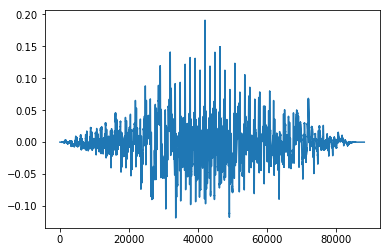

In [46]:
sampleLen = 44100
boolLen = 0
mixTrack, sr = sf.read('mixed_ch.wav')
premixTrack, sr = sf.read('premix.wav')
if len(premixTrack) > len(mixTrack):
    diffZ = np.zeros(((len(premixTrack)-len(mixTrack)),2))
    mixTrack = np.vstack((mixTrack, diffZ))
else:
    diffZ = np.zeros(((len(mixTrack)-len(premixTrack)),2))
    premixTrack = np.vstack((premixTrack, diffZ))
    boolLen = -1
#pprint.pprint(np.shape(mixTrack))
#pprint.pprint(np.shape(diffZ))

pprint.pprint(np.shape(mixTrack))
pprint.pprint(np.shape(premixTrack))
x = np.correlate(mixTrack[:sampleLen,1], premixTrack[:sampleLen,1], 'full')

plt.plot(x)
offset = np.argmax(x, axis=None)
offset = (2*sampleLen - 1)/2 - offset
#print(offset)

if offset is not 0:
    if boolLen is 0:
        premixTrack = np.roll(premixTrack, -offset)
    else:
        mixTrack = np.roll(mixTrack, -offset)

sf.write('premix_off.wav', premixTrack, mixsr)

In [47]:
path = '/scratch/rrs432/tracks'
#os.mkdir(path)
os.chdir(path)

In [55]:
!ls

45d6ad91-7559-4ea8-bcfd-491fa74d4230.ogg  mixed.wav
67cea412-42ab-4778-a221-100c33b68acc.ogg  premix_off.wav
a9a08cf9-d3b4-47bf-8103-a457da7480a2.ogg  premix.ogg
d15ecff8-a0d0-408b-bab7-931243e25421.ogg  premix.wav
mixed_ch.wav


In [56]:
mixsr=44100
mix_spec, sr = librosa.load('mixed.wav', sr=mixsr)
premix_spec, sr = librosa.load('premix_off.wav', sr=mixsr)
#premix_spec, sr = librosa.load('mixed.wav', sr=mixsr)
#mixTrack = np.matrix.transpose(mixTrack)
#premixTrack = np.matrix.transpose(premixTrack)
#mix_spec = librosa.to_mono(mixTrack)
#premix_spec = librosa.to_mono(premixTrack)

In [57]:
premix_data = librosa.amplitude_to_db(librosa.stft(premix_spec), ref=np.max)
print(np.shape(premix_data))

# plt.figure(figsize=(12, 3))
# librosa.display.specshow(premix_data, y_axis='linear')
# plt.colorbar(format='%+2.0f dB')
# plt.title('BandHub Mix Spectrogram')

(1025, 8537)


In [58]:
mix_data = librosa.amplitude_to_db(librosa.stft(mix_spec), ref=np.max)
print(np.shape(mix_data))

# plt.figure(figsize=(12, 3))
# librosa.display.specshow(mix_data, y_axis='linear')
# plt.colorbar(format='%+2.0f dB')
# plt.title('MARL Remix Spectrogram')

(1025, 8531)


In [54]:
diff_data = abs(np.subtract(premix_data,mix_data))
print(np.mean((diff_data)**2))

#rmse_unprocessed_nonzerost.append(np.mean((diff_data)**2))
plt.figure(figsize=(12, 3))
librosa.display.specshow(diff_data, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Diff Spectrogram')


ValueError: operands could not be broadcast together with shapes (1025,8537) (1025,8531) 

0.999969482421875
0.999969482421875


KeyboardInterrupt: 

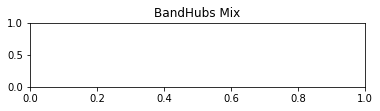

In [22]:
diffMix = premixTrack - mixTrack
print(np.amax(premixTrack))
print(np.amax(mixTrack))
time = np.linspace(0,len(premixTrack)/mixsr,num=len(premixTrack))
plt.subplot(311)
plt.title('BandHubs Mix')
plt.plot(time,premixTrack)
plt.subplot(312)
plt.title('MARL Remix')
plt.plot(time,mixTrack)
plt.subplot(313)
plt.title('Diff')
plt.plot(time,diffMix)

In [ ]:
indexRequired = [   0    1    2    3    4    5    7    8   10   11   14   16   17   18
   20   21   22   24   25   27   28   31   35   37   38   39   40   41
   42   43   44   46   48   50   51   53   55   57   59   60   61   65
   67   69   73   75   79   81   83   86   88   89   90   91   98   99
  100  102  103  104  105  107  108  109  111  114  116  117  119  120
  121  122  123  125  127  128  131  133  136  141  144  145  146  149
  153  154  156  158  161  163  165  168  169  170  171  172  173  176
  180  181  184  185  187  188  191  192  193  196  197  202  204  206
  207  208  209  213  214  216  217  218  220  224  225  226  227  229
  231  233  237  238  239  240  243  247  250  253  256  257  263  264
  266  268  270  272  273  277  278  279  280  284  288  289  292  295
  296  298  302  314  315  321  326  330  331  335  338  339  343  346
  349  350  354  356  358  362  369  372  374  375  376  377  380  381
  382  383  385  389  394  395  396  398  401  402  403  406  407  409
  411  412  417  419  430  432  433  435  437  439  448  454  457  461
  464  469  474  476  481  482  483  485  487  488  490  496  497  499
  500  504  507  508  511  512  516  517  522  523  525  526  527  533
  537  541  544  545  546  547  548  549  551  558  562  565  572  573
  574  575  576  578  579  583  585  586  587  588  589  590  593  594
  596  597  598  601  602  604  607  610  611  612  614  616  622  623
  624  625  627  628  629  630  631  632  633  634  635  636  637  640
  641  644  645  647  648  650  651  653  654  656  657  660  661  662
  663  664  665  667  668  672  673  674  678  681  683  684  685  686
  690  692  696  700  722  724  729  730  731  737  740  744  747  749
  750  761  765  766  769  773  780  781  794  797  803  805  808  809
  813  814  816  817  821  823  825  828  831  833  852  863  865  868
  871  872  873  884  886  890  892  895  897  900  903  907  909  910
  919  922  923  924  930  933  938  948  950  952  953  954  955  957
  958  965  969  996 1002 1006 1007 1013 1026 1028 1030 1032 1033 1034
 1035 1036 1037 1038 1039 1041 1042 1044 1045 1046 1047 1050 1051 1052
 1053 1054 1055 1056 1062 1063 1064 1065 1066 1067 1068 1069 1070 1072
 1073 1079 1080 1081 1082 1083 1084 1088 1089 1090 1091 1094 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1109 1110 1111 1113
 1114 1115 1116 1117 1120 1121 1123 1124 1125 1126 1127 1129 1131 1133
 1134 1135 1136 1137 1138 1139 1140 1144 1146 1147 1148 1149 1151 1153
 1154 1155 1156 1157 1158 1160 1161 1162 1163 1164 1165 1166 1168 1171
 1172 1175 1181 1182 1185 1187 1188 1189 1191 1193 1194 1195 1196 1197
 1199 1200 1201 1202 1203 1205 1207 1208 1211 1212 1213 1214 1215 1216
 1217 1218 1220 1222 1223 1224 1225 1226 1227 1228 1229 1230 1234 1235
 1236 1237 1239 1240 1241 1242 1246 1247 1248 1249 1250 1251 1252 1254
 1255 1256 1257 1258 1259 1260 1261 1262 1263 1265 1266 1267 1268 1269
 1270 1271 1272 1273 1274 1276 1278 1284 1285 1287 1288 1289 1290 1292
 1293 1295 1296 1297 1298 1299 1300 1301 1304 1307 1308 1310 1311 1312
 1313 1315 1316 1317 1318 1319 1320 1321 1324 1325 1326 1327 1329 1330
 1331 1332 1337 1339 1341 1344 1345 1346 1348 1349 1350 1352 1353 1354
 1355 1356 1357 1358 1359 1360 1362 1364 1365 1366 1367 1368 1369 1370
 1371 1372 1373 1374 1375 1376 1377 1379 1380 1381 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1391 1393 1395 1396 1399 1402 1403 1404 1405
 1408 1410 1411 1413 1416 1417 1418 1419 1420 1421 1422 1423 1424 1426
 1428 1429 1430 1431 1433 1434 1435 1437 1438 1439 1440 1441 1443 1444
 1446 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1462 1463
 1466 1471 1472 1473 1474 1475 1476 1477 1479 1481 1482 1483 1484 1485
 1486 1488 1489 1490 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502
 1503 1506 1507 1508 1509 1511 1512 1513 1514 1515 1517 1518 1519 1520
 1521 1524 1526 1527 1528 1529 1530 1532 1541 1542 1544 1545 1546 1548
 1549 1550 1551 1552 1553 1554 1556 1557 1558 1560 1562 1563 1565 1566
 1567 1568 1569 1570 1571 1572 1573 1574 1578 1579 1580 1581 1582 1583
 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1598 1599 1600
 1606 1607 1608 1609 1610 1611 1612 1614 1615 1616 1617 1618 1619 1620
 1621 1622 1623 1624 1626 1627 1629 1630 1631 1632 1634 1635 1636 1637
 1638 1639 1641 1642 1643 1645 1646 1647 1648 1650 1651 1652 1653 1655
 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669
 1671 1672 1673 1674 1675 1676 1677 1678 1679 1681 1682 1683 1684 1685
 1686 1687 1689 1690 1691 1692 1693 1696 1697 1698 1699 1700 1701 1703
 1704 1705 1707 1708 1709 1711 1712 1713 1715 1716 1717 1718 1719 1720
 1721 1722 1724 1725 1726 1727 1728 1729 1730 1731 1732 1734 1735 1736
 1737 1738 1739 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751
 1752 1753 1754 1755 1756 1757 1759 1760 1762 1763 1764 1765 1767 1768
 1769 1770 1771 1772 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783
 1785 1786 1787 1788 1789 1790 1792 1793 1794 1795 1796 1797 1798 1799
 1800 1801 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813
 1814 1815 1816 1818 1819 1820 1822 1823 1825 1826 1827 1828 1829 1830
 1831 1832 1833 1834 1835 1837 1838 1839 1840 1841 1844 1845 1846 1847
 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862
 1863 1864 1865 1866 1867 1868 1869 1870 1872 1874 1875 1876 1877 1878
 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892
 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1906 1909
 1910 1911 1912 1913 1914 1916 1917 1918 1919 1920 1921 1922 1923 1924
 1925 1926 1928 1929 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941
 1942 1944 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959
 1960 1961 1962 1963 1964 1965 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1993 1994 1995 1996 1997 1999 2000 2004 2005 2006 2007 2008 2010
 2011 2012 2013 2014 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025
 2026 2027 2028 2029 2030 2031 2032 2033 2035 2036 2037 2038 2039 2040
 2041 2042 2043 2045 2046 2048 2050 2051 2052 2053 2055 2056 2057 2058
 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073
 2074 2075 2076 2077 2079 2080 2082 2083 2084 2085 2086 2087 2088 2089
 2090 2091 2092 2093 2094 2095 2096 2097 2099 2101 2102 2103 2104 2105
 2107 2108 2109 2110 2111 2112 2113 2114 2115 2116 2118 2119 2120 2121
 2122 2123 2124 2125 2126 2127 2128 2131 2132 2133 2134 2135 2136 2137
 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2152
 2153 2154 2156 2157 2158 2159 2160 2161 2162 2163 2164 2166 2167 2168
 2169 2170 2171 2172 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184
 2185 2186 2187 2188 2189 2190 2191 2192 2193 2194 2195 2196 2197 2198
 2199 2200 2201 2202 2203 2204 2205 2207 2208 2209 2210 2211 2212 2213
 2219 2220 2222 2224 2225 2230 2231 2233 2241 2245 2246 2249 2252 2253
 2255 2256 2257 2258 2259 2260 2261 2264 2265 2269 2270 2272 2275 2276
 2277 2280 2281 2282 2285 2287 2288 2290 2293 2294 2295 2296 2297 2299
 2300 2302 2304 2305 2306 2307 2309 2310 2311 2312 2316 2317 2318 2321
 2323 2324 2325 2326 2331 2332 2333 2334 2335 2339 2340 2341 2342 2343
 2344 2346 2347 2349 2350 2351 2352 2354 2355 2356 2357 2358 2359 2360
 2361 2362 2363 2365 2367 2368 2369 2370 2371 2372 2373 2374 2375 2376
 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389 2392 2394 2395
 2396 2397 2398 2400 2401 2402 2403 2404 2405 2406 2407 2408 2409 2411
 2412 2413 2414 2415 2416 2419 2420 2421 2422 2423 2424 2425 2426 2427
 2428 2429 2433 2434 2438 2439 2440 2441 2442 2443 2444 2445 2447 2448
 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2462 2463
 2464 2465 2466 2467 2468 2469 2470 2471 2472 2474 2475 2476 2477 2478
 2482 2483 2484 2485 2486 2487 2488 2489 2490 2491 2492 2493 2494 2495
 2496 2497 2498 2499 2500 2501 2502 2503 2504 2505 2507 2508 2509 2510
 2511 2512 2514 2515 2516 2517 2518 2519 2521 2522 2523 2524 2525 2526
 2527 2528 2530 2531 2532 2533 2534 2535 2536 2537 2540 2541 2543 2544
 2545 2546 2547 2548 2550 2551 2552 2553 2554 2555 2556 2557 2558 2559
 2560 2561 2562 2563 2564 2565 2566 2567 2568 2569 2570 2571 2572 2573
 2574 2575 2576 2578 2579 2580 2582 2583 2584 2586 2587 2588 2589 2590
 2591 2592 2593 2594 2595 2596 2597 2598 2599 2600 2601 2603 2605 2609
 2612 2613 2614 2615 2616 2617 2618 2619 2620 2621 2622 2623 2624 2625
 2626 2627 2628 2629 2630 2631 2632 2633 2634 2635 2636 2637 2638 2639
 2640 2641 2642 2643 2644 2645 2648 2649 2650 2651 2652 2653 2654 2656
 2657 2658 2659 2660 2661 2664 2671 2672 2673 2674 2675 2677 2678 2679
 2680 2681 2682 2683 2685 2686 2687 2688 2689 2690 2691 2696 2697 2698
 2699 2700 2701 2702 2703 2704 2705 2706 2707 2708 2709 2710 2711 2712
 2713 2714 2716 2717 2718 2719 2720 2721 2722 2723 2724 2725 2726 2727
 2728 2729 2730 2731 2732 2733 2734 2735 2736 2737 2738 2739 2740 2741
 2742 2743 2744 2745 2746 2747 2748 2749 2750 2751 2752 2753 2754 2756
 2757 2758 2759 2760 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770
 2771 2772 2773 2774 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785
 2786 2787 2788 2789 2791 2794 2795 2797 2798 2799 2800 2801 2804 2805
 2806 2807 2809 2810 2816 2817 2818 2819 2820 2822 2823 2824 2825 2826
 2827 2828 2830 2831 2834 2836 2837 2838 2839 2840 2842 2843 2844 2845
 2846 2847 2848 2849 2850 2851 2852 2853 2854 2855 2856 2858 2859 2860
 2861 2864 2865 2866 2867 2868 2869 2870 2871 2872 2873 2874 2875 2876
 2877 2878 2880 2881 2884 2885 2886 2889 2890 2891 2892 2893 2894 2895
 2896 2897 2898 2899 2901 2902 2903 2904 2905 2906 2907 2908 2909 2910
 2911 2914 2915 2916 2917 2919 2920 2921 2922 2924 2925 2926 2927 2928
 2930 2931 2932 2934 2935 2937 2938 2939 2940 2941 2942 2945 2946 2947
 2948 2949 2950 2951 2952 2953 2954 2955 2956 2957 2958 2959 2960 2961
 2962 2964 2965 2966 2967 2968 2969 2971 2972 2973 2974 2976 2977 2978
 2979 2980 2981 2982 2983 2984 2986 2987 2992 2993 2994 2995 2996 2997
 2998 2999 3000 3002 3003 3004 3005 3007 3010 3011 3012 3013 3014 3015
 3016 3017 3018 3019 3020 3021 3023 3025 3026 3029 3030 3031 3032 3033
 3034 3035 3036 3037 3038 3039 3040 3041 3042 3043 3045 3046 3048 3049
 3050 3051 3052 3053 3055 3056 3057 3058 3059 3060 3061 3062 3063 3064
 3065 3066 3067 3068 3071 3072 3073 3074 3075 3076 3078 3079 3080 3081
 3082 3083 3084 3086 3087 3089 3090 3091 3092 3093 3094 3095 3096 3097
 3098 3100 3101 3102 3103 3104 3105 3106 3107 3108 3109 3110 3111 3112
 3113 3115 3116 3117 3118 3119 3121 3122 3123 3124 3125 3127 3128 3129
 3130 3132 3133 3134 3135 3136 3137 3138 3140 3141 3142 3143 3144 3145
 3146 3147 3148 3149 3150 3151 3152 3153 3154 3155 3156 3157 3158 3159
 3160 3161 3162 3163 3164 3165 3166 3167 3168 3169 3170 3171 3172 3173
 3174 3175 3176 3177 3178 3179 3180 3181 3182 3183 3184 3185 3186 3187
 3188 3189 3190 3191 3192 3193 3194 3195 3196 3197 3198 3199 3200 3201
 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213 3214 3215
 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227 3228 3229
 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241 3242 3243
 3244 3245 3246 3247 3248 3249 3250 3251 3253 3254 3255 3256 3257 3258
 3259 3260 3261 3262 3263 3264 3265 3266 3268 3269 3270 3271 3272 3273
 3274 3277 3278 3280 3281 3282 3283 3284 3286 3287 3288 3289 3291 3292
 3293 3294 3295 3300 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311
 3312 3313 3314 3315 3317 3321 3322 3323 3324 3325 3326 3327 3329 3330
 3331 3332 3333 3334 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344
 3345 3346 3348 3349 3350 3351 3352 3353 3354 3355 3356 3357 3358 3359
 3360 3361 3362 3363 3364 3365 3366 3367 3368 3369 3370 3371 3372 3373
 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384 3385 3386 3387
 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398 3400 3401 3402
 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412 3413 3414 3415 3416
 3418 3419 3420 3421 3422 3423 3424 3425 3426 3427 3428 3430 3431 3432
 3433 3434 3435 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446
 3447 3448 3450 3451 3452 3453 3454 3455 3457 3458 3459 3460 3461 3462
 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475 3476
 3477 3478 3479 3480 3481 3482 3483 3484 3485 3486 3487 3488 3489 3490
 3491 3492 3493 3494 3495 3496 3497 3498 3499 3500 3501 3502 3503 3504
 3505 3506 3507 3508 3509 3510 3511 3512 3513 3514 3515 3516 3517 3518
 3519 3520 3521 3522 3523 3524 3525 3526 3527 3528 3529 3530 3531 3532
 3533 3534 3535 3536 3537 3538 3539 3540 3541 3542 3543 3544 3545 3546
 3547 3549 3550 3551 3552 3553 3554 3555 3556 3557 3558 3559 3560 3561
 3562 3563 3564 3565 3566 3567 3568 3569 3570 3571 3572 3573 3574 3575
 3577 3578 3579 3581 3582 3583 3584 3586 3587 3589 3590 3592 3593 3594
 3595 3598 3599 3600 3601 3602 3603 3606 3607 3609 3610 3611 3612 3613
 3614 3615 3617 3618 3626 3628 3629 3632 3633 3634 3635 3636 3637 3639
 3640 3645 3646 3647 3649 3650 3651 3653 3654 3655 3656 3658 3659 3660
 3661 3662 3663 3664 3665 3666 3667 3669 3670 3671 3672 3674 3675 3678
 3679 3680 3681 3682 3683 3684 3687 3688 3689 3690 3691 3692 3693 3694
 3695 3697 3698 3699 3700 3701 3702 3703 3704 3705 3706 3707 3708 3709
 3710 3711 3712 3713 3714 3715 3716 3717 3718 3722 3723 3724 3725 3726
 3727 3728 3729 3730 3731 3732 3733 3734 3735 3736 3737 3738 3739 3741
 3742 3743 3744 3745 3746 3747 3748 3749 3750 3751 3752 3753 3754 3755
 3756 3757 3758 3759 3760 3761 3762 3763 3765 3766 3767 3768 3769 3770
 3771 3772 3773 3774 3775 3776 3777 3778 3779 3780 3781 3782 3783 3784
 3785 3786 3787 3788 3789 3790 3791 3792 3793 3794 3795 3796 3797 3798
 3799 3800 3801 3802 3803 3804 3805 3806 3807 3808 3809 3810 3811 3812
 3813 3814 3815 3816 3817 3818 3819 3820 3821 3822 3823 3824 3825 3826
 3827 3828 3829 3830 3831 3832 3833 3834 3835 3836 3837 3838 3839 3840
 3841 3842 3843 3844 3845 3846 3847 3848 3849 3850 3851 3852 3853 3854
 3855 3856 3857 3858 3859 3860 3861 3862 3863 3864 3865 3866 3867 3868
 3869 3870 3871 3872 3873 3874 3875 3876 3877 3878 3879 3880 3881 3882
 3883 3884 3885 3886 3887 3888 3890 3891 3893 3894 3895 3896 3897 3898
 3899 3900 3901 3902 3903 3904 3905 3906 3907 3908 3909 3910 3911 3912
 3913 3914 3915 3916 3917 3918 3919 3920 3921 3923 3924 3925 3926 3927
 3928 3929 3930 3931 3932 3933 3934 3935 3936 3937 3938 3939 3940 3941
 3942 3943 3944 3945 3946 3947 3949 3950 3951 3952 3953 3954 3955 3956
 3957 3958 3959 3960 3961 3962 3963 3964 3965 3966 3967 3968 3969 3970
 3971 3972 3973 3974 3975 3976 3977 3978 3979 3980 3981 3982 3983 3984
 3985 3986 3987 3988 3989 3990 3991 3992 3993 3994 3995 3996 3997 4000
 4001 4002 4003 4004 4005 4006 4007 4008 4009 4010 4011 4012 4013 4014
 4015 4016 4017 4018 4020 4021 4022 4023 4024 4025 4026 4027 4028 4029
 4030 4031 4032 4033 4034 4035 4036 4037 4038 4039 4040 4041 4042 4043
 4044 4045 4046 4047 4048 4049 4050 4051 4052 4053 4054 4055 4056 4058
 4059 4060 4061 4062 4063 4064 4065 4066 4067 4068 4069 4070 4071 4072
 4073 4074 4075 4076 4077 4078 4079 4080 4081 4082 4083 4084 4085 4086
 4087 4088 4089 4090 4091 4092 4093 4094 4095 4096 4101 4102 4108 4109
 4110 4111 4112 4113 4114 4115 4116 4117 4119 4121 4122 4123 4124 4125
 4126 4127 4128 4129 4130 4131 4132 4134 4135 4137 4138 4140 4141 4142
 4143 4144 4145 4146 4147 4148 4149 4150 4151 4152 4153 4154 4155 4156
 4157 4158 4159 4160 4161 4162 4163 4164 4165 4166 4167 4168 4169 4170
 4171 4172 4173 4174 4175 4176 4177 4178 4179 4180 4181 4182 4183 4184
 4185 4186 4187 4188 4189 4190 4191 4192 4193 4194 4195 4196 4197 4198
 4199 4200 4201 4202 4203 4204 4205 4206 4207 4208 4209 4210 4211 4212
 4213 4214 4215 4216 4217 4218 4219 4220 4221 4222 4223 4224 4225 4226
 4227 4228 4229 4230 4231 4232 4233 4234 4235 4236 4237 4238 4239 4240
 4241 4242 4243 4244 4246 4250 4251 4252 4253 4254 4255 4256 4257 4258
 4259 4260 4261 4262 4263 4264 4265 4266 4267 4268 4269 4270 4271 4272
 4273 4274 4275 4276 4277 4278 4279 4280 4281 4282 4283 4284 4285 4286
 4287 4288 4289 4290 4291 4292 4293 4295 4296 4298 4299 4300 4301 4302
 4303 4304 4305 4306 4307 4308 4309 4310 4311 4312 4313 4314 4315 4316
 4317 4318 4319 4320 4321 4322 4323 4324 4325 4326 4327 4328 4329 4330
 4331 4332 4333 4335 4336 4337 4338 4339 4340 4341 4342 4343 4344 4345
 4346 4347 4348 4349 4350 4351 4352 4353 4354 4355 4356 4358 4359 4360
 4361 4362 4363 4364 4365 4366 4367 4368 4369 4370 4371 4372 4373 4374
 4375 4376 4377 4378 4379 4380 4381 4382 4383 4384 4385 4386 4387 4388
 4389 4391 4392 4393 4394 4395 4396 4397 4398 4399 4400 4402 4403 4404
 4405 4406 4407 4408 4409 4410 4411 4412 4413 4414 4415 4416 4417 4418
 4419 4420 4421 4422 4423 4424 4425 4426 4427 4428 4429 4430 4431 4432
 4433 4434 4435 4436 4437 4438 4439 4440 4441 4442 4443 4444 4445 4446
 4447 4448 4449 4450 4451 4452 4453 4454 4455 4456 4457 4458 4459 4460
 4461 4462 4463 4464 4465 4466 4467 4468 4469 4470 4471 4472 4473 4474
 4475 4476 4477 4478 4479 4480 4481 4482 4483 4484 4485 4486 4487 4488
 4489 4490 4491 4492 4493 4494 4495 4496 4498 4499 4500 4501 4502 4503
 4504 4505 4506 4507 4508 4509 4510 4511 4512 4513 4514 4515 4516 4517
 4518 4519 4520 4521 4522 4523 4524 4525 4526 4527 4528 4529 4530 4531
 4532 4533 4534 4535 4536 4537 4538 4539 4540 4541 4542 4543 4544 4545
 4546 4547 4548 4549 4550 4551 4552 4553 4554 4555 4556 4557 4558 4559
 4560 4561 4562 4563 4564 4565 4566 4567 4568 4569 4570 4571 4572 4573
 4574 4575 4576 4577 4578 4579 4580 4581 4582 4583 4584 4585 4586 4587
 4588 4589 4590 4591 4592 4593 4594 4595 4596 4597 4598 4599 4600 4601
 4602 4603 4604 4605 4606 4607 4608 4609 4610 4611 4612 4613 4614 4615
 4616 4617 4618 4619 4620 4621 4622 4623 4624 4625 4626 4627 4628 4629
 4630 4631 4632 4633 4634 4635 4636 4637 4638 4639 4640 4641 4642 4643
 4644 4645 4646 4647 4648 4649 4650 4651 4652 4654 4655 4656 4657 4658
 4659 4660 4661 4662 4663 4664 4665 4666 4667 4668 4669 4670 4671 4672
 4673 4674 4675 4676 4677 4678 4679 4680 4681 4682 4683 4684 4685 4686
 4687 4688 4689 4690 4691 4692 4693 4694 4695 4696 4697 4698 4699 4700
 4701 4702 4703 4704 4705 4706 4707 4708 4709 4710 4711 4712 4713 4714
 4715 4716 4717 4718 4719 4720 4721 4722 4723 4724 4725 4726 4727 4728
 4729 4730 4731 4732 4733 4734 4735 4736 4737 4738 4739 4740 4741 4742
 4743 4744 4745 4746 4747 4748 4749 4750 4751 4752 4753 4754 4755 4756
 4757 4758 4759 4760 4761 4762 4763 4764 4765 4766 4767 4768 4769 4770
 4771 4772 4773 4774 4775 4776 4777 4778 4779 4780 4781 4782 4783 4784
 4785 4786 4787 4788 4789 4790 4791 4793 4794 4795 4796 4797 4798 4799
 4800 4801 4802 4803 4804 4805 4806 4807 4808 4809 4810 4811 4812 4813
 4814 4815 4816 4817 4818 4819 4820 4821 4822 4823 4824 4825 4826 4827
 4828 4829 4830 4831 4832 4833 4834 4835 4836 4837 4838 4839 4840 4841
 4842 4843 4844 4845 4846 4847 4848 4849 4850 4851 4852 4853 4854 4855
 4856 4857 4858 4859 4860 4861 4862 4863 4864 4865 4866 4867 4868 4869
 4870 4871 4872 4873 4874 4875 4876 4877 4878 4879 4880 4881 4882 4883
 4884 4885 4886 4887 4888 4889 4890 4891 4892 4893 4894 4895 4896 4897
 4898 4899 4900 4901 4902 4903 4904 4905 4906 4907 4908 4909 4910 4911
 4912 4913 4914 4915 4916 4917 4918 4919 4920 4921 4922 4923 4924 4925
 4926 4927 4928 4929 4930 4931 4932 4933 4934 4935 4936 4937 4938 4939
 4940 4941 4942 4943 4944 4945 4946 4947 4948 4949 4950 4951 4952 4953
 4954 4955 4956 4957 4958 4959 4960 4961 4962 4963 4964 4965 4966 4967
 4968 4969 4970 4971 4972 4973 4974 4975 4976 4977 4978 4979 4980 4981
 4982 4983 4984 4985 4986 4987 4988 4990 4991 4994 4995 4996 4997 4998
 4999 5000 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013
 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027 5028
 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041 5042
 5043 5044 5045 5046 5047 5048 5049 5050 5051 5053 5054 5055 5056 5057
 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069 5070 5071
 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083 5084 5085
 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097 5098 5099
 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111 5112 5113
 5114 5115 5116 5117 5118 5119 5120 5121 5122 5123 5124 5125 5126 5127
 5128 5129 5130 5131 5132 5134 5135 5136 5137 5138 5139 5140 5141 5142
 5143 5144 5145 5146 5147 5148 5149 5150 5151 5152 5153 5154 5155 5156
 5157 5158 5159 5160 5161 5162 5163 5164 5165 5166 5167 5168 5169 5170
 5171 5172 5173 5174 5175 5176 5177 5178 5179 5180 5181 5182 5183 5184
 5185 5186 5187 5188 5189 5190 5191 5192 5193 5194 5195 5196 5197 5198
 5199 5200 5201 5202 5203 5204 5205 5206 5207 5208 5209 5210 5211 5212
 5213 5214 5215 5216 5217 5218 5219 5220 5221 5222 5223 5224 5225 5226
 5227 5228 5229 5230 5231 5232 5233 5234 5235 5236 5237 5238 5239 5240
 5241 5242 5243 5244 5245 5246 5247 5248 5249 5250 5251 5252 5253 5254
 5255 5256 5257 5258 5259 5260 5261 5262 5263 5264 5265 5266 5267 5268
 5269 5270 5271 5272 5273 5274 5275 5276 5277 5278 5279 5280 5281 5282
 5283 5284 5285 5286 5287 5288 5289 5290 5291 5292 5293 5294 5295 5296
 5297 5298 5299 5300 5301 5302 5303 5304 5305 5306 5307 5308 5309 5310
 5311 5312 5313 5314 5315 5316 5317 5318 5319 5320 5321 5322 5323 5324
 5325 5326 5327 5328 5329 5330 5331 5332 5333 5334 5335 5336 5337 5338
 5339 5340 5341 5342 5343 5344 5345 5346 5347 5348 5349 5350 5351 5352
 5353 5354 5355 5356 5357 5358 5359 5360 5361 5362 5363 5364 5365 5366
 5367 5368 5369 5370 5371 5372 5373 5374 5375 5376 5377 5378 5379 5380
 5381 5382 5383 5384 5385 5386 5387 5388 5389 5390 5391 5392 5393 5394
 5395 5396 5397 5398 5399 5400 5401 5402 5403 5404 5405 5406 5407 5408
 5409 5410 5411 5412 5413 5414 5415 5416 5417 5418 5419 5420 5421 5422
 5423 5424 5425 5426 5427 5428 5429 5430 5431 5432 5433 5434 5435 5436
 5437 5438 5439 5440 5441 5442 5443 5444 5445 5446 5447 5448 5449 5450
 5451 5452 5453 5454 5455 5456 5457 5458 5459 5460 5461 5462 5463 5464
 5465 5466 5467 5468 5469 5470 5471 5472 5473 5474 5475 5476 5477 5478
 5479 5480 5481 5482 5483 5484 5485 5486 5487 5488 5489 5490 5491 5492
 5493 5494 5495 5496 5497 5498 5499 5500 5501 5502 5503 5504 5505 5506
 5507 5508 5509 5510 5511 5512 5513 5514 5515 5516 5517 5518 5519 5520
 5521 5522 5523 5524 5525 5526 5527 5528 5529 5530 5531 5532 5533 5534
 5535 5536 5537 5538 5539 5540 5541 5542 5543 5544 5545 5546 5547 5548
 5549 5550 5551 5552 5553 5554 5555 5556 5557 5558 5559 5560 5561 5562
 5563 5564 5565 5566 5567 5568 5569 5570 5571 5572 5573 5574 5575 5576
 5577 5578 5579 5580 5581 5582 5583 5584 5585 5586 5587 5588 5589 5590
 5591 5592 5593 5594 5595 5596 5597 5598 5599 5600 5601 5602 5603 5604
 5605 5606 5607 5608 5609 5610 5611 5612 5613 5614 5615 5616 5617 5618
 5619 5620 5621 5622 5623 5624 5625 5626 5627 5628 5629 5630 5631 5632
 5633 5634 5635 5636 5637 5638 5639 5640 5641 5642 5643 5644 5645 5646
 5647 5648 5649 5650 5651 5652 5653 5654 5655 5656 5657 5658 5659 5660
 5661 5662 5663 5664 5665 5666 5667 5668 5669 5670 5671 5672 5673 5674
 5675 5676 5677 5678 5679 5680 5681 5682 5683 5684 5685 5686 5687 5688
 5689 5690 5691 5692 5693 5694 5695 5696 5697 5698 5699 5700 5701 5702
 5703 5704 5705 5706 5707 5708 5709 5710 5711 5712 5713 5714 5715 5716
 5717 5718 5719 5720 5721 5722 5723 5724 5725 5726 5727 5728 5729 5730
 5731 5732 5733 5734 5735 5736 5737 5738 5739 5740 5741 5742 5743 5744
 5745 5746 5747 5748 5749 5750 5751 5752 5753 5754 5755 5756 5757 5758
 5759 5760 5761 5762 5763 5764 5765 5766 5767 5768 5769 5770 5771 5772
 5773 5774 5775 5776 5777 5778 5779 5780 5781 5782 5783 5784 5785 5786
 5787 5788 5789 5790 5791 5792 5793 5794 5795 5796 5797 5798 5799 5800
 5801 5802 5803 5804 5805 5806 5807 5808 5809 5810 5811 5812 5813 5814
 5815 5816 5817 5818 5819 5820 5821 5822 5823 5824 5825 5826 5827 5828
 5829 5830 5831 5832 5833 5834 5835 5836 5837 5838 5839 5840 5841 5842
 5843 5844 5845 5846 5847 5848 5849 5850 5851 5852 5853 5854 5855 5856
 5857 5858 5859 5860 5861 5862 5863 5864 5865 5866 5867 5868 5869 5870
 5871 5872 5873 5874 5875 5876 5877 5878 5879 5880 5881 5882 5883 5884
 5885 5886 5887 5888 5889 5890 5891 5892 5893 5894 5895 5896 5897 5898
 5899 5900 5901 5902 5903 5904 5905 5906 5907 5908 5909 5910 5911 5912
 5913 5914 5915 5916 5917 5918 5919 5920 5921 5922 5923 5924 5925 5926
 5927 5928 5929 5930 5931 5932 5933 5934 5935 5936 5937 5938 5939 5940
 5941 5942 5943 5944 5945 5946 5947 5948 5949 5950 5951 5952 5953 5954
 5955 5956 5957 5958 5959 5960 5961 5962 5963 5964 5965 5966 5967 5968
 5969 5970 5971 5972 5973 5974 5975 5976 5977 5978 5979 5980 5981 5982
 5983 5984 5985 5986 5987 5988 5989 5990 5991 5992 5993 5994 5995 5996
 5997 5998 5999 6000 6001 6002 6003 6004 6005 6006 6007 6008 6009 6010
 6011 6012 6013 6014 6015 6016 6017 6018 6019 6020 6021 6022 6023 6024
 6025 6026 6027 6028 6029 6030 6031 6032 6033 6034 6035 6036 6037 6038
 6039 6040 6041 6042 6043 6044 6045 6046 6047 6048 6049 6050 6051 6052
 6053 6054 6055 6056 6057 6058 6059 6060 6061 6062 6063 6064 6065 6066
 6067 6068 6069 6070 6071 6072 6073 6074 6075 6076 6077 6078 6079 6080
 6081 6082 6083 6084 6085 6086 6087 6088 6089 6090 6091 6092 6093 6094
 6095 6096 6097 6098 6099 6100 6101 6102 6103 6104 6105 6106 6107 6108
 6109 6110 6111 6112 6113 6114 6115 6116 6117 6118 6119 6120 6121 6122
 6123 6124 6125 6126 6127 6128 6129 6130 6131 6132 6133 6134 6135 6136
 6137 6138 6139 6140 6141 6142 6143 6144 6145 6146 6147 6148 6149 6150
 6151 6152 6153 6154 6155 6156 6157 6158 6159 6160 6161 6162 6163 6164
 6165 6166 6167 6168 6169 6170 6171 6172 6173 6174 6175 6176 6177 6178
 6179 6180 6181 6182 6183 6184 6185 6186 6187 6188 6189 6190 6191 6192
 6193 6194 6195 6196 6197 6198 6199 6200 6201 6202 6203 6204 6205 6206
 6207 6208 6209 6210 6211 6212 6213 6214 6215 6216 6217 6218 6219 6220
 6221 6222 6223 6224 6225 6226 6227 6228 6229 6230 6231 6232 6233 6234
 6235 6236 6237 6238 6239 6240 6241 6242 6243 6244 6245 6246 6247 6248
 6249 6250 6251 6252 6253 6254 6255 6256 6257 6258 6259 6260 6261 6262
 6263 6264 6265 6266 6267 6268 6269 6270 6271 6272 6273 6274 6275 6276
 6277 6278 6279 6280 6281 6282 6283 6284 6285 6286 6287 6288 6289 6290
 6291 6292 6293 6294 6295 6296 6297 6298 6299 6300 6301 6302 6303 6304
 6305 6306 6307 6308 6309 6310 6311 6312 6313 6314 6315 6316 6317 6318
 6319 6320 6321 6322 6323 6324 6325 6326 6327 6328 6329 6330 6331 6332
 6333 6334 6335 6336 6337 6338 6339 6340 6341 6342 6343 6344 6345 6346
 6347 6348 6349 6350 6351 6352 6353 6354 6355 6356 6357 6358 6359 6360
 6361 6362 6363 6364 6365 6366 6367 6368 6369 6370 6371 6372 6373 6374
 6375 6376 6377 6378 6379 6380 6381 6382 6383 6384 6385 6386 6387 6388
 6389 6390 6391 6392 6393 6394 6395 6396 6397 6398 6399 6400 6401 6402
 6403 6404 6405 6406 6407 6408 6409 6410 6411 6412 6413 6414 6415 6416
 6417 6418 6419 6420 6421 6422 6423 6424 6425 6426 6427 6428 6429 6430
 6431 6432 6433 6434 6435 6436 6437 6438 6439 6440 6441 6442 6443 6444
 6445 6446 6447 6448 6449 6450 6451 6452 6453 6454 6455 6456 6457 6458
 6459 6460 6461 6462 6463 6464 6465 6466 6467 6468 6469 6470 6471 6472
 6473 6474 6475 6476 6477 6478 6479 6480 6481 6482 6483 6484 6485 6486
 6487 6488 6489 6490 6491 6492 6493 6494 6495 6496 6497 6498 6499 6500
 6501 6502 6503 6504 6505 6506 6507 6508 6509 6510 6511 6512 6513 6514
 6515 6516 6517 6519 6520 6521 6522 6523 6524 6525 6526 6527 6528 6529
 6530 6531 6532 6533 6534 6535 6536 6537 6538 6539 6540 6541 6542 6543
 6544 6545 6546 6547 6548 6549 6550 6551 6552 6553 6554 6555 6556 6557
 6558 6559 6560 6561 6562 6563 6564 6565 6566 6567 6568 6569 6570 6571
 6572 6573 6574 6575 6576 6577 6578 6579 6580 6581 6582 6583 6584 6585
 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597 6598 6599
 6600 6601 6602 6603 6604 6605 6606 6607 6608 6609 6610 6611 6612 6613
 6614 6615 6616 6617 6618 6619 6620 6621 6622 6623 6624 6625 6626 6627
 6628 6629 6630 6631 6632 6633 6634 6635 6636 6637 6638 6639 6640 6641
 6642 6643 6644 6645 6646 6647 6648 6649 6650 6651 6652 6653 6654 6655
 6656 6657 6658 6659 6660 6661 6662 6663 6664 6665 6666 6667 6668 6669
 6670 6671 6672 6673 6674 6675 6676 6677 6678 6679 6680 6681 6682 6683
 6684 6685 6686 6687 6688 6689 6690 6691 6692 6693 6694 6695 6696 6697
 6698 6699 6700 6701 6702 6703 6704 6705 6706 6707 6708 6709 6710 6711
 6712 6713 6714 6715 6716 6717 6718 6719 6720 6721 6722 6723 6724 6725
 6726 6727 6728 6729 6730 6731 6732 6733 6734 6735 6736 6737 6738 6739
 6740 6741 6742 6743 6744 6745 6746 6747 6748 6749 6750 6751 6752 6753
 6754 6755 6756 6757 6758 6759 6760 6761 6762 6763 6764 6765 6766 6767
 6768 6769 6770 6771 6772 6773 6774 6775 6776 6777 6778 6779 6780 6781
 6782 6783 6784 6785 6786 6787 6788 6789 6790 6791 6792 6793 6794 6795
 6796 6797 6798 6799 6800 6801 6802 6803 6804 6805 6806 6807 6808 6809
 6810 6811 6812 6813 6814 6815 6816 6817 6818 6819 6820 6821 6822 6823
 6824 6825 6826 6827 6828 6829 6830 6831 6832 6833 6834 6835 6836 6837
 6838 6839 6840 6841 6842 6843 6844 6845 6846 6847 6848 6849 6850 6851
 6852 6853 6854 6855 6856 6857 6858 6859 6860 6861 6862 6863 6864 6865
 6866 6867 6868 6869 6870 6871 6872 6873 6874 6875 6876 6877 6878 6879
 6880 6881 6882 6883 6884 6885 6886 6887 6888 6889 6890 6891 6892 6893
 6894 6895 6896 6897 6898 6899 6900 6901 6902 6903 6904 6905 6906 6907
 6908 6909 6910 6911 6912 6913 6914 6915 6916 6917 6918 6919 6920 6921
 6922 6923 6924 6925 6926 6927 6928 6929 6930 6931 6932 6933 6934 6935
 6936 6937 6938 6939 6940 6941 6942 6943 6944 6945 6946 6947 6948 6949
 6950 6951 6952 6953 6954 6955 6956 6957 6958 6959 6960 6961 6962 6963
 6964 6965 6966 6967 6968 6969 6970 6971 6972 6973 6974 6975 6976 6977
 6978 6979 6980 6981 6982 6983 6984 6985 6986 6987 6988 6989 6990 6991
 6992 6993 6994 6995 6996 6997 6998 6999 7000 7001 7002 7003 7004 7005
 7006 7007 7008 7009 7010 7011 7012 7013 7014 7015 7016 7017 7018 7019
 7020 7021 7022 7023 7024 7025 7026 7027 7028 7029 7030 7031 7032 7033
 7034 7035 7036 7037 7038 7039 7040 7041 7042 7043 7044 7045 7046 7047
 7048 7049 7050 7051 7052 7053 7054 7055 7056 7057 7058 7059 7060 7061
 7062 7063 7064 7065 7066 7067 7068 7069 7070 7071 7072 7073 7074 7075
 7076 7077 7078 7079 7080 7081 7082 7083 7084 7085 7086 7087 7088 7089
 7090 7091 7092 7093 7094 7095 7096 7097 7098 7099 7100 7101 7102 7103
 7104 7105 7106 7107 7108 7109 7110 7111 7112 7113 7114 7115 7116 7117
 7118 7119 7120 7121 7122 7123 7124 7125 7126 7127 7128 7129 7130 7131
 7132 7133 7134 7135 7136 7137 7138 7139 7140 7141 7142 7143 7144 7145
 7146 7147 7148 7149 7150 7151 7152 7153 7154 7155 7156 7157 7158 7159
 7160 7161 7162 7163 7164 7165 7166 7167 7168 7169 7170 7171 7172 7173
 7174 7175 7176 7177 7178 7179 7180 7181 7182 7183 7184 7185 7186 7187
 7188 7189 7190 7191 7192 7193 7194 7195 7196 7197 7198 7199 7200 7201
 7202 7203 7204 7205 7206 7207 7208 7209 7210 7211 7212 7213 7214 7215
 7216 7217 7218 7219 7220 7221 7222 7223 7224 7225 7226 7227 7228 7229
 7230 7231 7232 7233 7234 7235 7236 7237 7238 7239 7240 7241 7242 7243
 7244 7245 7246 7247 7248 7249 7250 7251 7252 7253 7254 7255 7256 7257
 7258 7259 7260 7261 7262 7263 7264 7265 7266 7267 7268 7269 7270 7271
 7272 7273 7274 7275 7276 7277 7278 7279 7280 7281 7282 7283 7284 7285
 7286 7287 7288 7289 7290 7291 7292 7293 7294 7295 7296 7297 7298 7299
 7300 7301 7302 7303 7304 7305 7306 7307 7308 7309 7310 7311 7312 7313
 7314 7315 7316 7317 7318 7319 7320 7321 7322 7323 7324 7325 7326 7327
 7328 7329 7330 7331 7332 7333 7334 7335 7336 7337 7338 7339 7340 7341
 7342 7343 7344 7345 7346 7347 7348 7349 7350 7351 7352 7353 7354 7355
 7356 7357 7358 7359 7360 7361 7362 7363 7364 7365 7366 7367 7368 7369
 7370 7371 7372 7373 7374 7375 7376 7377 7378 7379 7380 7381 7382 7383
 7384 7385 7386 7387 7388 7389 7390 7391 7392 7393 7394 7395 7396 7397
 7398 7399 7400 7401 7402 7403 7404 7405 7406 7407 7408 7409 7410 7411
 7412 7413 7414 7415 7416 7417 7418 7419 7420 7421 7422 7423 7424 7425
 7426 7427 7428 7429 7430 7431 7432 7433 7434 7435 7436 7437 7438 7439
 7440 7441 7442 7443 7444 7445 7446 7447 7448 7449 7450 7451 7452 7453
 7454 7455 7456 7457 7458 7459 7460 7461 7462 7463 7464 7465 7466 7467
 7468 7469 7470 7471 7472 7473 7474 7475 7476 7477 7478 7479 7480 7481
 7482 7483 7484 7485 7486 7487 7488 7489 7490 7491 7492 7493 7494 7495
 7496 7497 7498 7499 7500 7501 7502 7503 7504 7505 7506 7507 7508 7509
 7510 7511 7512 7513 7514 7515 7516 7517 7518 7519 7520 7521 7522 7523
 7524 7525 7526 7527 7528 7529 7530 7531 7532 7533 7534 7535 7536 7537
 7538 7539 7540 7541 7542 7543 7544 7545 7546 7547 7548 7549 7550 7551
 7552 7553 7554 7555 7556 7557 7558 7559 7560 7561 7562 7563 7564 7565
 7566 7567 7568 7569 7570 7571 7572 7573 7574 7575 7576 7577 7578 7579
 7580 7581 7582 7583 7584 7585 7586 7587 7588 7589 7590 7591 7592 7593
 7594 7595 7596 7597 7598 7599 7600 7601 7602 7603 7604 7605 7606 7607
 7608 7609 7610 7611 7612 7613 7614 7615 7616 7617 7618 7619 7620 7621
 7622 7623 7624 7625 7626 7627 7628 7629 7630 7631 7632 7633 7634 7635
 7636 7637 7638 7639 7640 7641 7642 7643 7644 7645 7646 7647 7648 7649
 7650 7651 7652 7653 7654 7655 7656 7657 7658 7659 7660 7661 7662 7663
 7664 7665 7666 7667 7668 7669 7670 7671 7672 7673 7674 7675 7676 7677
 7678 7679 7680 7681 7682 7683 7684 7685 7686 7687 7688 7689 7690 7691
 7692 7693 7694 7695 7696 7697 7698 7699 7700 7701 7702 7703 7704 7705
 7706 7707 7708 7709 7710 7711 7712 7713 7714 7715 7716 7717 7718 7719
 7720 7721 7722 7723 7724 7725 7726 7727 7728 7729 7730 7731 7732 7733
 7734 7735 7736 7737 7738 7739 7740 7741 7742 7743 7744 7745 7746 7747
 7748 7749 7750 7751 7752 7753 7754 7755 7756 7757 7758 7759 7760 7761
 7762 7763 7764 7765 7766 7767 7768 7769 7770 7771 7772 7773 7774 7775
 7776 7777 7778 7779 7780 7781 7782 7783 7784 7785 7786 7787 7788 7789
 7790 7791 7792 7793 7794 7795 7796 7797 7798 7799 7800 7801 7802 7803
 7804 7805 7806 7807 7808 7809 7810 7811 7812 7813 7814 7815 7816 7817
 7818 7819 7820 7821 7822 7823 7824 7825 7826 7827 7828 7829 7830 7831
 7832 7833 7834 7835 7836 7837 7838 7839 7840 7841 7842 7843 7844 7845
 7846 7847 7848 7849 7850 7851 7852 7853 7854 7855 7856 7857 7858 7859
 7860 7861 7862 7863 7864 7865 7866 7867 7868 7869 7870 7871 7872 7873
 7874 7875 7876 7877 7878 7879 7880 7881 7882 7883 7884 7885 7886 7887
 7888 7889 7890 7891 7892 7893 7894 7895 7896 7897 7898 7899 7900 7901
 7902 7903 7904 7905 7906 7907 7908 7909 7910 7911 7912 7913 7914 7915
 7916 7917 7918 7919 7920 7921 7922 7923 7924 7925 7926 7927 7928 7929
 7930 7931 7932 7933 7934 7935 7936 7937 7938 7939 7940 7941 7942 7943
 7944 7945 7946 7947 7948 7949 7950 7951 7952 7953 7954 7955 7956 7957
 7958 7959 7960 7961 7962 7963 7964 7965 7966 7967 7968 7969 7970 7971
 7972 7973 7974 7975 7976 7977 7978 7979 7980 7981 7982 7983 7984 7985
 7986 7987 7988 7989 7990 7991 7992 7993 7994 7995 7996 7997 7998 7999
 8000 8001 8002 8003 8004 8005 8006 8007 8008 8009 8010 8011 8012 8013]